# Data Acquaision (Do not run it Now)

In [158]:
import json
import pandas as pd 

playerID = "977"

for season in range(1996,2016):
    # The stats.nba.com API wants season as "1996-97"
    seasonString = str(season) + '-' + str(season+1)[2:]
    # The stats.nba.com endpoint we are using is http://stats.nba.com/stats/shotchartdetail
    # More info on endpoints: https://github.com/seemethere/nba_py/wiki/stats.nba.com-Endpoint-Documentation
    shot_chart_url = 'http://stats.nba.com/stats/shotchartdetail?Period=0&VsConference=&LeagueID=00&LastNGames=0&TeamID=0&PlayerPosition=&Position=&Location=&Outcome=&ContextMeasure=FGA&DateFrom=&StartPeriod=&DateTo=&OpponentTeamID=0&ContextFilter=&RangeType=&Season=' + seasonString + '&AheadBehind=&PlayerID=977&EndRange=&VsDivision=&PointDiff=&RookieYear=&GameSegment=&Month=0&ClutchTime=&StartRange=&EndPeriod=&SeasonType=Regular+Season&SeasonSegment=&GameID='
    shot_chart_url = 'http://stats.nba.com/stats/shotchartdetail?Period=0&VsConference=&LeagueID=00&LastNGames=0&TeamID=0&PlayerPosition=&Position=&Location=&Outcome=&ContextMeasure=FGA&DateFrom=&StartPeriod=&DateTo=&OpponentTeamID=0&ContextFilter=&RangeType=&Season=' + seasonString + '&AheadBehind=&PlayerID=977&EndRange=&VsDivision=&PointDiff=&RookieYear=&GameSegment=&Month=0&ClutchTime=&StartRange=&EndPeriod=&SeasonType=Playoffs&SeasonSegment=&GameID='
    #print(shot_chart_url)
    

# Data Combination (Do not run it Now)

In [5]:
seasons = []
for season in range(1996,2016):
    seasonString = './regular/'+str(season) + '.json'
    json_data=open(seasonString).read()
    data = json.loads(json_data)
    # Split response into headers and content
    headers = data['resultSets'][0]['headers']
    shots = data['resultSets'][0]['rowSet']
    # Create pandas dataframe to hold the data
    shot_df = pd.DataFrame(shots, columns=headers)
    # add extra column for season
    shot_df['SEASON'] = str(season) + '-' + str(season+1)[2:]
    # add extra column for playoff flag
    shot_df['playoffs'] = 0
    seasons.append(shot_df)
    
for season in range(1996,2016):
    seasonString = './playoffs/'+str(season) + '.json'
    json_data=open(seasonString).read()
    data = json.loads(json_data)
    # Split response into headers and content
    headers = data['resultSets'][0]['headers']
    shots = data['resultSets'][0]['rowSet']
    # Create pandas dataframe to hold the data
    shot_df = pd.DataFrame(shots, columns=headers)
    # add extra column for season
    shot_df['SEASON'] = str(season) + '-' + str(season+1)[2:]
    # add extra column for playoff flag
    shot_df['playoffs'] = 1
    seasons.append(shot_df)
    
kobe = pd.concat(seasons)
print(len(kobe['GRID_TYPE']))    
kobe.to_csv("kobe.csv")


30697


# Contribution 1 Sorting and Partition Functions

In [4]:
import math
import operator
import copy

def sort_and_partition(data, name, n):
    stat = {}
    for i, (d, x) in enumerate(zip(data[name], data['shot_made_flag'])):
        if not (d in stat) :
            stat[d] = [0, 0]
        if x == 1:
            stat[d][0] += 1
            stat[d][1] += 1
        else:
            stat[d][1] += 1
    for key, value in stat.items():
        stat[key] = value[0] / value[1]
    stat = sorted(stat.items(), key=operator.itemgetter(1))
    index_map = {}
    for i, (key, value) in enumerate(stat):
        index_map[key] = math.floor(i / n)
    length = math.ceil(len(stat) / n)
    da = {}
    zeros = [0 for i in range(length)]
    for i in range(length):
        da[name + str(i)] = []
    for i, l in enumerate(data[name]):
        for j in range(length):
            if j == index_map[l]:
                da[name + str(j)].append(1)
            else:
                da[name + str(j)].append(0)
    return pd.DataFrame(data = da)

def sort_and_partition2(data, name, n):
    stat = {}
    for i, (d, x) in enumerate(zip(data[name], data['shot_made_flag'])):
        if i < 5000:
            continue
        if not (d in stat) :
            stat[d] = [0, 0]
        if x == 1:
            stat[d][0] += 1
            stat[d][1] += 1
        else:
            stat[d][1] += 1
    for key, value in stat.items():
        stat[key] = value[0] / value[1]
    stat = sorted(stat.items(), key=operator.itemgetter(1))
    index_map = {}
    for i, (key, value) in enumerate(stat):
        index_map[key] = math.floor(i / n)
    length = math.ceil(len(stat) / n)
    da = {}
    zeros = [0 for i in range(length)]
    for i in range(length):
        da[name + str(i)] = []
    for i, l in enumerate(data[name]):
        for j in range(length):
            if j == index_map[l]:
                da[name + str(j)].append(1)
            else:
                da[name + str(j)].append(0)
    return pd.DataFrame(data = da)

def sort_and_partition3(data, name, k = -1):
    stat = {}
    for i, (d, x) in enumerate(zip(data[name], data['shot_made_flag'])):
        if not (d in stat) :
            stat[d] = [0, 0]
        if x == 1:
            stat[d][0] += 1
            stat[d][1] += 1
        else:
            stat[d][1] += 1
    shoot_min = 1
    shoot_max = 0
    for key, v in stat.items():
        stat[key] = v[0] / v[1]
        if stat[key] > shoot_max:
            shoot_max = stat[key]
        if stat[key] < shoot_min:
            shoot_min = stat[key]
    if k == -1:
        n = 1
        stat = sorted(stat.items(), key=operator.itemgetter(1))
        index_map = {}
        for i, (key, value) in enumerate(stat):
            index_map[key] = math.floor(i / n)
        length = math.ceil(len(stat) / n)
        da = {}
        zeros = [0 for i in range(length)]
        for i in range(length):
            da[name + str(i)] = []
        for i, l in enumerate(data[name]):
            for j in range(length):
                if j == index_map[l]:
                    da[name + str(j)].append(1)
                else:
                    da[name + str(j)].append(0)
        return pd.DataFrame(data = da)
        
    #print(stat)
    #k-means
    converge = False
    while not converge:
        c = np.random.uniform(shoot_min, shoot_max, [1, k])[0]
        #print(c)
        c_old = np.zeros(c.shape)
        clusters = np.zeros(len(stat))
        error = 0
        for i in range(k):
            error += abs(c_old[i] - c[i])
        count = 0
        while error != 0:
            for i, (_, v) in enumerate(stat.items()):
                distances = [abs(v - c[j]) for j in range(k)]
                cluster = np.argmin(distances)
                clusters[i] = cluster
            c_old = copy.deepcopy(c)
            for i in range(k):
                points = [stat[key] for j, (key, _) in enumerate(stat.items()) if clusters[j] == i]
                c[i] = np.mean(points)
            error = 0
            for i in range(k):
                error += abs(c_old[i] - c[i])
            count += 1
            if count > 100:
                break
            if error == 0:
                converge = True
        #print('count', count)
        #print('c', c)
    print('k-means result:', clusters)
    #end k-means
    for i, (key, _) in enumerate(stat.items()):
        stat[key] = clusters[i]
    
    da = {}
    zeros = [0 for i in range(k)]
    for i in range(k):
        da[name + str(i)] = []
    for i, l in enumerate(data[name]):
        for j in range(k):
            if j == stat[l]:
                da[name + str(j)].append(1)
            else:
                da[name + str(j)].append(0)
    return pd.DataFrame(data = da)

# Contribution 2: Compete Data Generation and the calculation of the accuracy of categorical features

In [23]:
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

def feature_accuracy(data, feature):
    stat = {}
    for i, (d, x) in enumerate(zip(data[feature], data['shot_made_flag'])):
        if i < 5000:
            continue
        if not (d in stat) :
            stat[d] = [0, 0]
        if x == 1:
            stat[d][0] += 1
            stat[d][1] += 1
        else:
            stat[d][1] += 1
    for k, v in stat.items():
        stat[k] = v[0] / v[1]
    dt = {feature + '_accuracy': []}
    for l in data[feature]:
        if l in stat:
            dt[feature + '_accuracy'].append(stat[l])
        else:
            dt[feature + '_accuracy'].append(0.5)
    return pd.DataFrame(data = dt)

allData = pd.read_csv('data.csv', encoding='utf-8-sig')
completeData = pd.read_csv('kobe.csv', encoding='utf-8-sig')
referenceData = completeData[[u'GAME_ID',u'GAME_EVENT_ID',u'SHOT_MADE_FLAG']]
referenceData['GAME_ID'] = referenceData['GAME_ID'].astype('int')
referenceData['GAME_EVENT_ID'] = referenceData['GAME_EVENT_ID'].astype('int')
referenceData['SHOT_MADE_FLAG'] = referenceData['SHOT_MADE_FLAG'].astype('float')
unknown_data = allData[allData['shot_made_flag'].isnull()]#.reset_index()
known_data = allData[allData['shot_made_flag'].notnull()]#.reset_index()

for index,unknonw_i in unknown_data.iterrows():
    game_id = unknonw_i['game_id']
    event_id = unknonw_i['game_event_id']
    true_i = referenceData.loc[(referenceData['GAME_ID']==(game_id)) & (referenceData['GAME_EVENT_ID'] == event_id)]    
    true_flag = true_i['SHOT_MADE_FLAG'].values
    unknown_data.set_value(index, 'shot_made_flag', true_flag)
final_complete_data = unknown_data.append(known_data)

## Add a feature of home or visit
list = []
for row in final_complete_data['matchup']:
    if '@' in str(row):
        list.append(0)
    else:
        list.append(1)

final_complete_data['home_field'] = pd.DataFrame(list)

## Add a feature of angle
DEGREE_UNIT = 0.01
data = final_complete_data
angles = {'angle' : [], 'layup': []}
for x, y in zip(data['loc_x'], data['loc_y']):
    if x == 0 and y == 0:
        angles['angle'].append(0.0)
        angles['layup'].append(1)
    else:
        angles['angle'].append(math.floor(abs(np.arctan2(y, x) * 180 / np.pi) / DEGREE_UNIT))
        angles['layup'].append(0)
angles = pd.DataFrame(data = angles)
final_complete_data["angle"] = angles["angle"]
final_complete_data["layup"] = angles["layup"]

## Add feature
season_new = feature_accuracy(data, "seconds_remaining")
final_complete_data["seconds_remaining_accuracy"] = season_new["seconds_remaining_accuracy"]

season_new = feature_accuracy(data, "shot_distance")
final_complete_data["shot_distance_accuracy"] = season_new["shot_distance_accuracy"]

season_new = feature_accuracy(data, "minutes_remaining")
final_complete_data["minutes_remaining_accuracy"] = season_new["minutes_remaining_accuracy"]

season_new = feature_accuracy(data, "period")
final_complete_data["period_accuracy"] = season_new["period_accuracy"]

season_new = feature_accuracy(data, "shot_type")
final_complete_data["shot_type_accuracy"] = season_new["shot_type_accuracy"]

season_new = feature_accuracy(data, "action_type")
final_complete_data["action_type_accuracy"] = season_new["action_type_accuracy"]

season_new = feature_accuracy(data, "lat")
final_complete_data["lat_accuracy"] = season_new["lat_accuracy"]

season_new = feature_accuracy(data, "lon")
final_complete_data["lon_accuracy"] = season_new["lon_accuracy"]

season_new = feature_accuracy(data, "angle")
final_complete_data["angle_accuracy"] = season_new["angle_accuracy"]

season_new = feature_accuracy(data, "season")
final_complete_data["season_accuracy"] = season_new["season_accuracy"]

## Final data set
final_complete_data = final_complete_data.reset_index()
final_complete_data.to_csv('Complete_Data.csv')
print(final_complete_data.shape) 
unknown_data = final_complete_data.head(5000)
unknown_data.to_csv('unknown_data.csv')
known_data = final_complete_data.tail(30697-5000)
known_data.to_csv('known_data.csv')

(30697, 39)


# Optional Showing features and corresponding hit rate

In [2]:
feature_name='minutes_remaining'
data = known_data
data[feature_name] = data[feature_name].astype('object')
data_features = data[feature_name];
data_features = pd.unique(data_features)
#print(data_features)
hit_rate = np.zeros((data_features.shape[0],1),dtype=np.float32)
i = 0
for type in data_features:
    sub_type = data.loc[data[feature_name] == type]
    nb_success_hit = sub_type.loc[sub_type['shot_made_flag'] == 1]
    nb_success_hit = nb_success_hit.shape[0]
    nb_fail_hit = sub_type.loc[sub_type['shot_made_flag'] == 0]
    nb_fail_hit = nb_fail_hit.shape[0]
    hit_rate[i] = nb_success_hit/(nb_success_hit+nb_fail_hit)
    i = i+1
hit_rate = hit_rate.reshape(-1)
# plt.figure(figsize=(12,4))    
# plt.bar(data_features,hit_rate)
# plt.show()

In [3]:
feature_name='minutes_remaining'
data = unknown_data
data[feature_name] = data[feature_name].astype('object')
data_features = data[feature_name];
data_features = pd.unique(data_features)
#print(data_features)
hit_rate = np.zeros((data_features.shape[0],1),dtype=np.float32)
i = 0
for type in data_features:
    sub_type = data.loc[data[feature_name] == type]
    nb_success_hit = sub_type.loc[sub_type['shot_made_flag'] == 1]
    nb_success_hit = nb_success_hit.shape[0]
    nb_fail_hit = sub_type.loc[sub_type['shot_made_flag'] == 0]
    nb_fail_hit = nb_fail_hit.shape[0]
    hit_rate[i] = nb_success_hit/(nb_success_hit+nb_fail_hit)
    i = i+1
hit_rate = hit_rate.reshape(-1)
# plt.figure(figsize=(12,4))    
# plt.bar(data_features,hit_rate)
# plt.show()

# Contribution 3: Important feature creation: Heat point

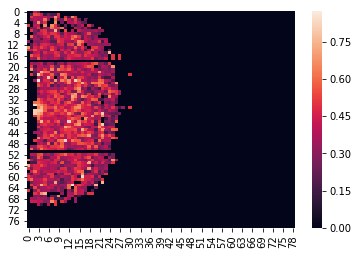

In [24]:
import math
import numpy as np
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

partition = 69
min_x, max_x =  min(data['loc_x']), max(data['loc_x'])
min_y, max_y =  min(data['loc_y']), max(data['loc_y'])

width_x = (max_x - min_x) // partition
width_y = (max_y - min_y) // partition
grid = []

for i in range(partition):
    start_x = min_x + (i) * (max_x - min_x) // partition
    end_x = min_x + (i + 1) * (max_x - min_x) // partition
    for j in range(partition):   
        start_y = min_y + (j) * (max_y - min_y) // partition
        end_y = min_y + (j + 1) * (max_y - min_y) // partition
        grid.append([start_x, end_x, start_y, end_y])
# print(len(grid))

        
grid_prob = {}
for current_row in zip(final_complete_data['loc_x'], final_complete_data['loc_y'], final_complete_data['shot_made_flag']):
    x, y, made = current_row
    int_made = int(made)
    for g in grid:
        s_x, e_x, s_y, e_y = g
        if s_x <= x and x <= e_x and s_y <= y and y <= e_y:
            grid_prob[((s_x + e_x)//2, (s_y + e_y)//2, int_made)] = grid_prob.get(((s_x + e_x)//2, (s_y + e_y)//2, int_made), 0) + 1
# print(grid_prob)

overall_prob = {}
for k in grid_prob:
    mid_x, mid_y, made = k
    for z in grid_prob:
        if z != k:
            inner_mid_x, inner_mid_y, inner_made = z
            if mid_x == inner_mid_x and mid_y == inner_mid_y:
#                 print(grid_prob[(mid_x, mid_y, made)], grid_prob[(mid_x, mid_y, inner_made)])
                if made == 1 and inner_made == 0:
                    overall_prob[(mid_x, mid_y)] = grid_prob[(mid_x, mid_y, made)] / (grid_prob[(mid_x, mid_y, made)] + grid_prob[(mid_x, mid_y, inner_made)])
                else:
                    overall_prob[(mid_x, mid_y)] = grid_prob[(mid_x, mid_y, inner_made)] / (grid_prob[(mid_x, mid_y, made)] + grid_prob[(mid_x, mid_y, inner_made)])

overall_x, overall_y, overall_val = [], [], []

heat_grid = np.zeros(shape=(partition+10,partition+10))
#print(heat_grid)
for k, v in overall_prob.items():
    x, y = k
    grid_x = (x - (min_x)) // width_x
    grid_y = (y - (min_y)) // width_y
    overall_x.append(grid_x)
    overall_y.append(grid_y)
    overall_val.append(v)

for x, y, v in zip(overall_x, overall_y, overall_val):
    #print(x, y, v)
    heat_grid[x][y] = v
    #print('Now heat grid', heat_grid[x][y])

# a = np.random.random((16, 16))
# print(type(a))
#print(heat_grid)
ax = sns.heatmap(heat_grid)
# print(overall_x)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.bar(overall_x, overall_y, overall_val)
# fig = plt.figure(figsize=(16, 8))
# ax1 = fig.add_subplot(111, projection='3d')  
# ax1.bar3d(overall_x, overall_y, overall_val, 1, 1, 0.5, shade=True)
# plt.show()

acc = []
for x, y in zip(known_data['loc_x'], known_data['loc_y']):
    grid_x = (x - (min_x)) // width_x
    grid_y = (y - (min_y)) // width_y
    prob = heat_grid[grid_x][grid_y]
    acc.append(prob)
df = pd.DataFrame({'xy_acc':acc})
known_data.insert(0, 'acc', acc)
#print(known_data)

acc = []
for x, y in zip(unknown_data['loc_x'], unknown_data['loc_y']):
    grid_x = (x - (min_x)) // width_x
    grid_y = (y - (min_y)) // width_y
    prob = heat_grid[grid_x][grid_y]
    acc.append(prob)
df = pd.DataFrame({'xy_acc':acc})
unknown_data.insert(0, 'acc', acc)
final_complete_data = unknown_data.append(known_data)

# Data pre-processing and features selections

In [25]:
from sklearn import preprocessing

## Decide the data set
data = final_complete_data

## Quantization of features
seconds = sort_and_partition2(data, 'seconds_remaining', 10)
mins = sort_and_partition2(data, 'minutes_remaining', 2)
seasons = sort_and_partition2(data, 'season', 1)
opponent = sort_and_partition2(data, 'opponent', 15)
distance = sort_and_partition2(data, 'shot_distance', 30)
period = sort_and_partition2(data, 'period', 4)

## dummy coded features
dummy_action_type = pd.get_dummies(data[[u'action_type']])
dummy_combined_shot_type = pd.get_dummies(data[[u'combined_shot_type']])
dummy_opponent = pd.get_dummies(data[u'opponent'].astype('category'))
dummy_shot_zone_area = pd.get_dummies(data[u'shot_zone_area'].astype('category'))
dummy_shot_zone_basic = pd.get_dummies(data[u'shot_zone_basic'].astype('category'))
dummy_shot_type = pd.get_dummies(data[u'shot_type'].astype('category'))
dummy_home_feild = pd.get_dummies(data[u'home_field'].astype('category'))
dummy_playoffs = pd.get_dummies(data[u'playoffs'].astype('category'))
dummy_period = pd.get_dummies(data[u'period'].astype('category'))

#Predictors
X = data[[#u'lat', u'lon', 
          u'loc_x',u'loc_y',
          u'shot_distance',
          #u'angle',
          #u'minutes_remaining',
          u'period',
          u'period_accuracy',
          u'seconds_remaining',
          u'seconds_remaining_accuracy',
          #u'season_accuracy',
          u'acc'
         ]]

X = pd.concat([X, \
               mins, \
               seasons,\
               ##opponent,\
               ##distance,\
               ##angles,\
               ##dummy_playoffs,\
               ##dummy_home_feild,\
               ##dummy_combined_shot_type,\
               dummy_period,\
               dummy_action_type,\
               dummy_shot_type,\
               dummy_shot_zone_area,\
               dummy_shot_zone_basic\
               ], axis = 1)
X_test = X.head(5000)
X_train = X.tail(25697)

#Dependent
y = data[u'shot_made_flag']
y_test = y.head(5000)
y_train = y.tail(25697)

#Dataframe to matrix
X_test = X_test.as_matrix()
X_train = X_train.as_matrix()
y_test = y_test.as_matrix()
y_train = y_train.as_matrix()

#Print Shapoe
print(X_train.shape)
print(X_test.shape)

(25697, 113)
(5000, 113)


# Logistic Regression

In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)

LR = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, \
                        intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', \
                        max_iter=10000, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
LR.fit(X_train,y_train)
y_predict_proba_LR = LR.predict_proba(X_test)
score_test = log_loss(y_test, y_predict_proba_LR[:,1])
y_predict_proba_LR_train = LR.predict_proba(X_train)
score_training= log_loss(y_train, y_predict_proba_LR_train[:,1])
accuracy = accuracy_score(y_test, LR.predict(X_test))
print('Accuracy: %f' %accuracy)
print('Log loss train: %f' %score_training)
print('Log loss test: %f' %score_test)

Accuracy: 0.683400
Log loss train: 0.597207
Log loss test: 0.599575


# K-Fold Validation of LR: Testing the robustness of our model

In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.model_selection import KFold

n_folds = 6
kf = KFold(n_folds)
kf.get_n_splits(X)
logloss = np.zeros((1,n_folds),dtype=np.double)
for k, (train, test) in enumerate(kf.split(X_train,y_train)):
     LR = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, \
                         intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', \
                         max_iter=10000, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
     LR.fit(X_train[train],y_train[train])
     y_predict_proba_LR_kfold = LR.predict_proba(X_train[test])
     logloss[0][k] = log_loss(y_train[test], y_predict_proba_LR_kfold[:,1])
print('Log loss: %f' %np.mean(logloss))

Log loss: 0.602955


# Decision Tree

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

print('Decision tree with gini criterion')
clf_gini = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 2)
clf_gini.fit(X_train, y_train)
y_predict_proba_clf_gini = clf_gini.predict_proba(X_test)
score = log_loss(y_test, y_predict_proba_clf_gini[:,1]) 
print('Log loss: %f' %score)

print('Decision tree with entropy criterion')
clf_entropy = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
clf_entropy.fit(X_train, y_train)
y_predict_proba_clf_entropy = clf_entropy.predict_proba(X_test)
score = log_loss(y_test, y_predict_proba_clf_entropy[:,1]) 
print('Log loss: %f' %score)


Decision tree with gini criterion
Log loss: 0.620508
Decision tree with entropy criterion
Log loss: 0.620508


# Random Forest

In [21]:
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)

# RFC = RandomForestClassifier()
# parameters_RFC = {'n_estimators':[100],'criterion':['entropy'],'random_state':[42]}
# grid_search_RFC = GridSearchCV(RFC, parameters_RFC)                             
# grid_search_RFC.fit(X_train,y_train)
# best_n_estimators_RFC = grid_search_RFC.best_params_['n_estimators']
# best_criterion_RFC = grid_search_RFC.best_params_['criterion']

RFC_Best = RandomForestClassifier(n_estimators=200, criterion='entropy')
RFC_Best.fit(X_train,y_train)
y_predict_proba_RFC = RFC_Best.predict_proba(X_test)
accuracy_score_RFC = accuracy_score(y_test, RFC_Best.predict(X_test))
roc_auc_score_RFC = roc_auc_score(y_test, y_predict_proba_RFC[:,1])
score = log_loss(y_test, y_predict_proba_RFC[:,1])

#print('The best parameter \'n_estimators\' is: %d' %best_n_estimators_RFC)
#print('The best parameter \'criterion\' is: %s' %best_criterion_RFC)
#print('The testing accuracy (accuracy_score) is: %f' %accuracy_score_RFC)
print('The roc_auc_score is: %f' %roc_auc_score_RFC)
print('Logloss: %f' %score)

The roc_auc_score is: 0.707574
Logloss: 0.611778


# AdaBoost

In [29]:
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)

# RFC = RandomForestClassifier()
# parameters_RFC = {'n_estimators':[100],'criterion':['entropy'],'random_state':[42]}
# grid_search_RFC = GridSearchCV(RFC, parameters_RFC)                             
# grid_search_RFC.fit(X_train,y_train)
# best_n_estimators_RFC = grid_search_RFC.best_params_['n_estimators']
# best_criterion_RFC = grid_search_RFC.best_params_['criterion']

Ada_Best = AdaBoostClassifier(n_estimators=500, learning_rate=0.005)
Ada_Best.fit(X_train,y_train)
y_predict_proba_Ada = Ada_Best.predict_proba(X_test)
accuracy_score_Ada = accuracy_score(y_test, Ada_Best.predict(X_test))
roc_auc_score_Ada = roc_auc_score(y_test, y_predict_proba_Ada[:,1])
score = log_loss(y_test, y_predict_proba_Ada[:,1])

#print('The best parameter \'n_estimators\' is: %d' %best_n_estimators_RFC)
#print('The best parameter \'criterion\' is: %s' %best_criterion_RFC)
#print('The testing accuracy (accuracy_score) is: %f' %accuracy_score_RFC)
print('The roc_auc_score is: %f' %roc_auc_score_Ada)
print('Logloss: %f' %score)

The roc_auc_score is: 0.706663
Logloss: 0.659983


# GBDT

In [30]:
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)

GBC_Best = GradientBoostingClassifier(n_estimators=200,learning_rate=0.031,max_depth=9)
GBC_Best.fit(X_train,y_train)
y_predict_proba_GBC = GBC_Best.predict_proba(X_test)
accuracy_score_GBC = accuracy_score(y_test, GBC_Best.predict(X_test))
roc_auc_score_GBC = roc_auc_score(y_test, y_predict_proba_GBC[:,1])
score = log_loss(y_test, y_predict_proba_GBC[:,1])

#print('The best parameter \'n_estimators\' is: %d' %best_n_estimators_RFC)
#print('The best parameter \'criterion\' is: %s' %best_criterion_RFC)
#print('The testing accuracy (accuracy_score) is: %f' %accuracy_score_RFC)
print('The roc_auc_score is: %f' %roc_auc_score_GBC)
print('Logloss: %f' %score)

The roc_auc_score is: 0.711519
Logloss: 0.608473


# XGBoost

In [ ]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)
from sklearn.model_selection import GridSearchCV

# parameters = {'n_estimators':[200],\
#               'learning_rate':[0.03],\
#               'max_depth':[6],\
#              }
# XGB = XGBClassifier(num_class=2,objective='multi:softprob')
# grid_search_XGB = GridSearchCV(XGB, parameters)                             
# grid_search_XGB.fit(X_train,y_train)
# best_n_estimators_XGB = grid_search_XGB.best_params_['n_estimators']
# best_learning_rate_XGB = grid_search_XGB.best_params_['learning_rate']
# best_max_depth_XGB = grid_search_XGB.best_params_['max_depth']

# XGB_Best = XGBClassifier(n_estimators=best_n_estimators_XGB,\
#                           learning_rate=best_learning_rate_XGB,\
#                      num_class=2,\
#                      min_child_weight = 9,\
#                      max_depth=best_max_depth_XGB,\
#                      objective='multi:softprob')

XGB_Best = XGBClassifier(n_estimators=200,\
                         learning_rate=0.031,\
                         num_class=2,\
                         min_child_weight = 9,\
                         max_depth=7,\
                         objective='multi:softprob')

XGB_Best.fit(X_train,y_train)
y_predict_proba_XGB = XGB_Best.predict_proba(X_test)
accuracy_score_XGB = accuracy_score(y_test, XGB_Best.predict(X_test))
roc_auc_score_XGB = roc_auc_score(y_test, y_predict_proba_XGB[:,1])
score = log_loss(y_test, y_predict_proba_XGB[:,1])
print('Log loss: %f' %score)

## Time Series Test

In [392]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss)

## Decide the training set
data = final_complete_data

## Quantization of features
seconds = sort_and_partition(data, 'seconds_remaining', 10)
mins = sort_and_partition(data, 'minutes_remaining', 3)
seasons = sort_and_partition(data, 'season', 4)
opponent = sort_and_partition(data, 'opponent', 3)
distance = sort_and_partition(data, 'shot_distance', 1)
angles = sort_and_partition(data, 'angle', 40)

## dummy coded features
dummy_action_type = pd.get_dummies(data[[u'action_type']])
dummy_combined_shot_type = pd.get_dummies(data[[u'combined_shot_type']])
dummy_period = pd.get_dummies(data[u'period'].astype('category'))   
dummy_playoffs = pd.get_dummies(data[u'playoffs'].astype('category'))
dummy_opponent = pd.get_dummies(data[u'opponent'].astype('category'))
dummy_season = pd.get_dummies(data[u'season'].astype('category'))
dummy_shot_type = pd.get_dummies(data[u'shot_type'].astype('category'))
dummy_shot_zone_area = pd.get_dummies(data[u'shot_zone_area'].astype('category'))
dummy_shot_zone_basic = pd.get_dummies(data[u'shot_zone_basic'].astype('category'))
dummy_home_feild = pd.get_dummies(data[u'home_field'].astype('category'))
dummy_mins = pd.get_dummies(data[u'minutes_remaining'].astype('category'))
#dummy_seconds = pd.get_dummies(data[u'seconds_remaining'].astype('category'))

X = data[[u'lat', 
          u'lon', 
          u'shot_distance',
          u'loc_x',
          u'loc_y',
          u'angle',
          u'seconds_remaining',
          #u'minutes_remaining',
          u'period',
          u'game_date',
         ]]

#Predictors
X = pd.concat([X, \
               #mins, \
               dummy_mins, \
               #dummy_seconds,\
               #seconds,\
               #seasons,\
               #opponent,\
               #distance,\
               #angles,\
               #dummy_playoffs,\
               #dummy_home_feild,\
               #dummy_combined_shot_type,\
               dummy_shot_type,\
               #dummy_opponent,\
               dummy_season,\
               dummy_action_type,\
               #dummy_period,\
               dummy_shot_zone_area,\
               dummy_shot_zone_basic\
               ], axis = 1)
X_test = X.head(5000)
X_train = X.tail(25697)

#Dependent
y = data[u'shot_made_flag']
y_test = y.head(5000)
y_train = y.tail(25697)

#
Known_Data_Transformed = pd.concat([X_train,y_train],axis=1)
Unknown_Data_Transformed = pd.concat([X_test,y_test],axis=1)



In [393]:
predic_prob = np.zeros((5000,1),dtype=float)
predic = np.zeros((5000,1),dtype=float)
i=0
start = 0
for raw_date in pd.unique(Unknown_Data_Transformed['game_date']):
    Sub_Known_Data_Transformed = Known_Data_Transformed[Known_Data_Transformed.apply(lambda x: x['game_date'] < raw_date, axis=1)]
    Sub_Known_Data_Transformed = Sub_Known_Data_Transformed.drop(['game_date'], axis=1)
    number_allowable_data = Sub_Known_Data_Transformed.shape[0]
    #print(raw_date)
    #print(number_allowable_data)
    
    #Dataframe to matrix training
    X_sub_training = Sub_Known_Data_Transformed.drop(['shot_made_flag'], axis=1)
    X_sub_training = X_sub_training.as_matrix()
    y_sub_train = Sub_Known_Data_Transformed['shot_made_flag']
    y_sub_train = y_sub_train.as_matrix()
      
    #Training Model
    LR = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True, \
                            intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', \
                            max_iter=10000, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
    LR.fit(X_sub_training,y_sub_train)
    
    #Prediction Process
    to_predict = Unknown_Data_Transformed[Unknown_Data_Transformed.apply(lambda x: x['game_date'] == raw_date, axis=1)]
    to_predict = to_predict.drop(['shot_made_flag','game_date'], axis=1)
    to_predict = to_predict.as_matrix()
    y_predict_proba_LR = LR.predict_proba(to_predict)
    number_predict = y_predict_proba_LR.shape[0]
    y_predict_proba = y_predict_proba_LR[:,1]
    y_predict_proba = y_predict_proba.reshape(-1,1)
    predic_prob[start:start+number_predict] = y_predict_proba
    y_predict = LR.predict(to_predict)
    y_predict = y_predict.reshape(-1,1)
    predic[start:start+number_predict] = y_predict
    
    #Prediction for next date
    start = start+number_predict
    if start >= 200:
        break



In [394]:
y_test = Unknown_Data_Transformed['shot_made_flag']
y_test = y_test.as_matrix()
y_test_sub = y_test[0:start]
accuracy = accuracy_score(y_test_sub, predic[0:start])
score_test = log_loss(y_test_sub, predic_prob[0:start])
print('accuracy %f' %accuracy)
print('log loss %f' %score_test)

accuracy 0.751244
log loss 0.560622
